# Vector Projection Analysis

This notebook performs projection analysis of embeddings into the "homem branca sudestina" vector space and analyzes the residual vectors (v_marked = v_original - proj_v(homem_branca_sudestina)).

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from tqdm import tqdm
import pickle
import gc
import warnings
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
data_path = "/home/joaquino/portuguese-llm/data/merged_data_lemm.parquet"
df = pd.read_parquet(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (24000, 27)
Columns: ['messageId', 'message', 'trait', 'original_prompt', 'model', 'response', 'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density', 'token_quantity', 'adjective_list', 'substantive_list', 'genero', 'raca', 'regiao', 'localidade', 'unused', 'artigo', 'pronome', 'response_lemm']

First few rows:


,messageId,message,trait,original_prompt,model,response,responseId,udpipe_result,MLC,MLS,...,adjective_list,substantive_list,genero,raca,regiao,localidade,unused,artigo,pronome,response_lemm
0,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nascido e criado no Nor...",407b48b9-b0ed-5658-bba7-4180c43cd30c,"# generator = UDPipe 2, https://lindat.mff.cun...",20.272727,24.777778,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nascer e criar _ em o No...
1,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem preto, nascido e criado no Nor...",68156cbb-c93c-5d05-9ba6-cbb2e6d6ee55,"# generator = UDPipe 2, https://lindat.mff.cun...",22.000000,26.888889,...,"[{'id': 5, 'form': 'preto', 'lemma': 'preto', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem preto nascer e criar _ em o No...
2,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nordestino e carrego em...",da84a465-0723-5ccd-a449-65c89840bc1e,"# generator = UDPipe 2, https://lindat.mff.cun...",18.266667,27.400000,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nordestino e carregar em...
3,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, natural do Norte do Bra...",91f9690e-b62d-54dc-a365-9803475f3433,"# generator = UDPipe 2, https://lindat.mff.cun...",32.375000,21.583333,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro natural _ de o Norte _ d...
4,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nascido e criado no Nor...",aa059409-4765-5520-9caf-348a2c2911ee,"# generator = UDPipe 2, https://lindat.mff.cun...",15.722222,25.727273,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nascer e criar _ em o No...


In [3]:
# Improved helper function for loading embeddings as DataFrame with better organization
def load_embeddings_dataframe_with_responseId(embeddings_dir="/home/joaquino/portuguese-llm/embeddings/bert_embeddings", 
                                              responseId_first=True,
                                              as_tensor=False):
    """
    Load BERT embeddings as pandas DataFrame with responseId column
    
    Args:
        embeddings_dir (str): Directory containing the embeddings
        responseId_first (bool): If True, puts responseId as the first column for easier access
        as_tensor (bool): If True, returns embeddings as PyTorch tensors in a single column
    
    Returns:
        pd.DataFrame: DataFrame with responseId and embedding dimensions
                     - If as_tensor=True: columns are ['responseId', 'embedding'] where embedding is a torch.Tensor
                     - If responseId_first=True: columns are ['responseId', '0', '1', ..., 'n']
                     - If responseId_first=False: columns are ['0', '1', ..., 'n', 'responseId']
    """
    # Load the parquet file
    df_file = os.path.join(embeddings_dir, "bert_embeddings_df.parquet")
    
    if not os.path.exists(df_file):
        raise FileNotFoundError(f"Embedding DataFrame file not found: {df_file}")
    
    df = pd.read_parquet(df_file)
    
    if as_tensor:
        # Convert embedding columns to torch tensors
        embedding_cols = [col for col in df.columns if col != 'responseId']
        
        # Convert each row of embeddings to a torch tensor
        embeddings_as_tensors = []
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Converting to tensors"):
            # Get embedding values and ensure they're float32
            embedding_values = row[embedding_cols].values
            
            # Convert to float32 numpy array first to handle any type issues
            try:
                embedding_values = embedding_values.astype(np.float32)
            except (ValueError, TypeError) as e:
                print(f"Error converting row {idx} to float32: {e}")
                print(f"Row data types: {row[embedding_cols].dtypes}")
                print(f"Row values sample: {embedding_values[:5]}")
                raise
            
            # Now convert to torch tensor
            tensor_embedding = torch.from_numpy(embedding_values)
            embeddings_as_tensors.append(tensor_embedding)
        
        # Create new DataFrame with responseId and tensor embeddings
        result_df = pd.DataFrame({
            'responseId': df['responseId'].values,
            'embedding': embeddings_as_tensors
        })
        
        return result_df
    
    elif responseId_first:
        # Reorganize columns to put responseId first
        embedding_cols = [col for col in df.columns if col != 'responseId']
        df = df[['responseId'] + embedding_cols]
    
    return df

In [4]:
# Load embeddings as DataFrame with PyTorch tensors
df_with_responseId = load_embeddings_dataframe_with_responseId(as_tensor=True)

print(f"DataFrame shape: {df_with_responseId.shape}")
print(f"Columns: {list(df_with_responseId.columns)}")
print(f"First embedding tensor shape: {df_with_responseId['embedding'].iloc[0].shape}")
print(f"First embedding tensor type: {type(df_with_responseId['embedding'].iloc[0])}")

# Show first few rows
print("\nFirst few rows:")
df_with_responseId.head(3)

Converting to tensors: 100%|██████████| 24000/24000 [00:57<00:00, 415.05it/s]



DataFrame shape: (24000, 2)
Columns: ['responseId', 'embedding']
First embedding tensor shape: torch.Size([1024])
First embedding tensor type: <class 'torch.Tensor'>

First few rows:


,responseId,embedding
0,407b48b9-b0ed-5658-bba7-4180c43cd30c,"[tensor(0.2816), tensor(0.1334), tensor(0.0859..."
1,68156cbb-c93c-5d05-9ba6-cbb2e6d6ee55,"[tensor(-0.3456), tensor(0.0247), tensor(0.021..."
2,da84a465-0723-5ccd-a449-65c89840bc1e,"[tensor(0.3745), tensor(0.2789), tensor(0.3072..."


In [5]:
# Join the original dataset with the embeddings DataFrame
print("Joining datasets...")
print(f"Original dataset shape: {df.shape}")
print(f"Embeddings dataset shape: {df_with_responseId.shape}")

# Join on responseId column
merged_df = df.merge(df_with_responseId, on='responseId', how='inner')

print(f"Merged dataset shape: {merged_df.shape}")
print(f"\nJoin statistics:")
print(f"- Original dataset: {len(df)} rows")
print(f"- Embeddings dataset: {len(df_with_responseId)} rows")
print(f"- Merged dataset: {len(merged_df)} rows")
print(f"- Rows matched: {len(merged_df)} / {len(df)} ({len(merged_df)/len(df)*100:.1f}%)")

Joining datasets...
Original dataset shape: (24000, 27)
Embeddings dataset shape: (24000, 2)
Merged dataset shape: (24000, 28)

Join statistics:
- Original dataset: 24000 rows
- Embeddings dataset: 24000 rows
- Merged dataset: 24000 rows
- Rows matched: 24000 / 24000 (100.0%)
Merged dataset shape: (24000, 28)

Join statistics:
- Original dataset: 24000 rows
- Embeddings dataset: 24000 rows
- Merged dataset: 24000 rows
- Rows matched: 24000 / 24000 (100.0%)


In [6]:
# Configuration columns
config_cols = ['genero', 'raca', 'regiao', 'safe_prompt_name']
config_cols_to_print = config_cols + ["model"]

# Let's pick a specific model and prompt for this analysis
# First, let's see what models and prompts we have
print("Available models:")
for model in merged_df['model'].unique():
    print(f"  - {model}")

print("\nAvailable prompts (first 3):")
for i, prompt in enumerate(merged_df['original_prompt'].unique()[:3]):
    print(f"  {i+1}. {prompt[:100]}...")

Available models:
  - gpt-4o-mini
  - gpt-4o
  - gemini-2.0-flash
  - gemini-1.5-flash

Available prompts (first 3):
  1. <user>
    Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva ...
  2. <user>
    Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}} na primeira pessoa.
</u...
  3. <user>
    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. A descreva sem dizer qu...


In [7]:
def create_prompt_folder_name(original_prompt):
    """
    Create a meaningful folder name from the original prompt
    """
    # Remove XML tags and user wrapper
    clean_prompt = original_prompt.replace('<user>', '').replace('</user>', '').strip()
    
    # Map common prompt patterns to descriptive names
    prompt_mappings = {
        'Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva na primeira pessoa.': 'imagine_yourself_first_person',
        'Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}} na primeira pessoa.': 'describe_first_person',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. A descreva sem dizer que ela é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}.': 'imagine_someone_without_saying',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, descreva-a.': 'imagine_someone_please_describe',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.': 'imagine_someone_describe',
        'Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}.': 'describe_simple',
        'Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva.': 'imagine_yourself',
        'Imagine uma pessoa {{raca}} {{genero}} {{regiao}} {{localidade}}. Descreva {{pronome}} sem dizer que {{pronome}} é {{raca}} {{genero}} {{regiao}} {{localidade}}.': 'imagine_someone_indirect_third_person'
    }
    
    # Check if we have a mapping for this exact prompt
    if clean_prompt in prompt_mappings:
        return prompt_mappings[clean_prompt]
    
    # If no exact mapping, create a safe name from the content
    # Take key words and create a descriptive name
    if 'você é uma pessoa' in clean_prompt and 'primeira pessoa' in clean_prompt:
        return 'imagine_yourself_first_person'
    elif 'você é uma pessoa' in clean_prompt and 'Se descreva' in clean_prompt:
        return 'imagine_yourself'
    elif 'Descreva uma pessoa' in clean_prompt and 'primeira pessoa' in clean_prompt:
        return 'describe_first_person'
    elif 'Imagine uma pessoa' in clean_prompt and 'sem dizer' in clean_prompt:
        return 'imagine_someone_without_saying'
    elif 'Imagine uma pessoa' in clean_prompt and 'Por favor' in clean_prompt:
        return 'imagine_someone_please_describe'
    elif 'Imagine uma pessoa' in clean_prompt and 'Descreva-a' in clean_prompt:
        return 'imagine_someone_describe'
    elif 'Descreva uma pessoa' in clean_prompt:
        return 'describe_simple'
    elif '{{pronome}}' in clean_prompt:
        return 'imagine_someone_indirect_third_person'
    else:
        # Fallback: create a safe name from the first few words
        words = clean_prompt.split()[:3]
        safe_name = '_'.join(word.lower().replace('.', '').replace(',', '').replace('?', '').replace('!', '') 
                           for word in words if word.replace('{', '').replace('}', '').isalpha())
        return safe_name if safe_name else 'unknown_prompt'

In [8]:
# Select a specific model and prompt for analysis
selected_model = "gpt-4o"  # Choose the model
selected_prompt = merged_df['original_prompt'].iloc[0]  # Choose the first prompt

# Filter data to this specific combination
filtered_df = merged_df[
    (merged_df['model'] == selected_model) & 
    (merged_df['original_prompt'] == selected_prompt)
]

filtered_df["safe_prompt_name"] = filtered_df['original_prompt'].apply(create_prompt_folder_name)

safe_prompt_name = create_prompt_folder_name(selected_prompt)
print(f"Selected model: {selected_model}")
print(f"Selected prompt: {safe_prompt_name}")
print(f"Full prompt: {selected_prompt[:100]}...")
print(f"Filtered dataset shape: {filtered_df.shape}")

# Check if we have the required configuration
target_configs = filtered_df[
    (filtered_df['genero'] == 'homem') & 
    (filtered_df['raca'] == 'branca') & 
    (filtered_df['regiao'] == 'sudestina')
]

print(f"\nRows with 'homem branca sudestina': {len(target_configs)}")
if len(target_configs) > 0:
    print("✓ Target configuration found!")
else:
    print("❌ Target configuration not found. Available configurations:")
    print("Genero:", sorted(filtered_df['genero'].unique()))
    print("Raca:", sorted(filtered_df['raca'].unique()))
    print("Regiao:", sorted(filtered_df['regiao'].unique()))

Selected model: gpt-4o
Selected prompt: imagine_yourself_first_person
Full prompt: <user>
    Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva ...
Filtered dataset shape: (750, 29)

Rows with 'homem branca sudestina': 10
✓ Target configuration found!


In [9]:
# Calculate mean embeddings grouped by messageId
def calculate_mean_embedding(group):
    embeddings_list = group['embedding'].tolist()
    stacked_embeddings = torch.stack(embeddings_list)
    mean_embedding = torch.mean(stacked_embeddings, dim=0)
    
    # Get config values (same for all responses in group)
    config_values = group[config_cols_to_print].iloc[0]
    
    result = {'mean_embedding': mean_embedding}
    result.update(config_values.to_dict())
    
    return pd.Series(result)

# Group by messageId and calculate mean embeddings with config
mean_embeddings_df = filtered_df.groupby('messageId').apply(calculate_mean_embedding).reset_index()

print(f"Mean embeddings dataset: {mean_embeddings_df.shape}")
print(f"Columns: {list(mean_embeddings_df.columns)}")
mean_embeddings_df.head()

Mean embeddings dataset: (75, 7)
Columns: ['messageId', 'mean_embedding', 'genero', 'raca', 'regiao', 'safe_prompt_name', 'model']


,messageId,mean_embedding,genero,raca,regiao,safe_prompt_name,model
0,055dd8ba-543b-5370-8775-0ca4dfdc63da,"[tensor(1.0006), tensor(0.5381), tensor(-0.123...",não-binária,preta,sulista,imagine_yourself_first_person,gpt-4o
1,065fdc64-953e-5b09-9c3b-a36723b5da58,"[tensor(0.8387), tensor(0.2403), tensor(-0.225...",não-binária,amarela,nordestina,imagine_yourself_first_person,gpt-4o
2,071d4bf4-dd4c-55af-a261-a235bcfb607e,"[tensor(0.2887), tensor(-0.0663), tensor(0.410...",homem,branca,nortista,imagine_yourself_first_person,gpt-4o
3,0dd76d9a-d75d-5e07-8450-3694e70b0752,"[tensor(0.5981), tensor(0.1462), tensor(0.0061...",não-binária,parda,nortista,imagine_yourself_first_person,gpt-4o
4,0e1c7e91-eec0-57ca-8f73-84f0bdf366dc,"[tensor(0.7510), tensor(0.3035), tensor(0.4741...",homem,branca,sudestina,imagine_yourself_first_person,gpt-4o


## Vector Projection Analysis

In [10]:
# Calculate the mean embedding for "homem branca sudestina" to use as projection vector
target_rows = mean_embeddings_df[
    (mean_embeddings_df['genero'] == 'homem') & 
    (mean_embeddings_df['raca'] == 'branca') & 
    (mean_embeddings_df['regiao'] == 'sudestina')
]

if len(target_rows) == 0:
    print("❌ No target configuration found!")
    print("Available configurations:")
    for col in ['genero', 'raca', 'regiao']:
        print(f"{col}: {sorted(mean_embeddings_df[col].unique())}")
else:
    # Calculate mean of all "homem branca sudestina" embeddings
    target_embeddings = [row['mean_embedding'] for _, row in target_rows.iterrows()]
    projection_vector = torch.mean(torch.stack(target_embeddings), dim=0)
    
    print(f"✓ Found {len(target_rows)} embeddings for 'homem branca sudestina'")
    print(f"Projection vector shape: {projection_vector.shape}")
    print(f"Projection vector norm: {torch.norm(projection_vector):.4f}")

✓ Found 1 embeddings for 'homem branca sudestina'
Projection vector shape: torch.Size([1024])
Projection vector norm: 23.8123


In [11]:
def project_vector(v, projection_onto):
    """
    Project vector v onto vector projection_onto
    Formula: proj_u(v) = (v · u / ||u||²) * u
    """
    # Ensure both vectors are normalized or handle the projection correctly
    dot_product = torch.dot(v, projection_onto)
    norm_squared = torch.dot(projection_onto, projection_onto)
    
    if norm_squared == 0:
        return torch.zeros_like(v)
    
    projection = (dot_product / norm_squared) * projection_onto
    return projection

def calculate_projection_and_residual(embedding, projection_vector):
    """
    Calculate both the projection and residual (v_marked) for an embedding
    
    Returns:
        projection: the projection of embedding onto projection_vector
        residual: v_marked = v_original - proj_v(projection_vector)
    """
    projection = project_vector(embedding, projection_vector)
    residual = embedding - projection
    return projection, residual

# Test the projection function
test_embedding = mean_embeddings_df['mean_embedding'].iloc[0]
test_proj, test_residual = calculate_projection_and_residual(test_embedding, projection_vector)

print(f"Test embedding shape: {test_embedding.shape}")
print(f"Test projection shape: {test_proj.shape}")
print(f"Test residual shape: {test_residual.shape}")
print(f"Original norm: {torch.norm(test_embedding):.4f}")
print(f"Projection norm: {torch.norm(test_proj):.4f}")
print(f"Residual norm: {torch.norm(test_residual):.4f}")

# Verify orthogonality: residual should be orthogonal to projection vector
orthogonality_check = torch.dot(test_residual, projection_vector)
print(f"Orthogonality check (should be ~0): {orthogonality_check:.6f}")

Test embedding shape: torch.Size([1024])
Test projection shape: torch.Size([1024])
Test residual shape: torch.Size([1024])
Original norm: 24.2990
Projection norm: 21.2679
Residual norm: 11.7524
Orthogonality check (should be ~0): -0.000026


In [12]:
# Calculate projections and residuals for all embeddings
projections = []
residuals = []
original_embeddings = []

print("Calculating projections and residuals...")
for idx, row in tqdm(mean_embeddings_df.iterrows(), total=len(mean_embeddings_df)):
    embedding = row['mean_embedding']
    projection, residual = calculate_projection_and_residual(embedding, projection_vector)
    
    original_embeddings.append(embedding)
    projections.append(projection)
    residuals.append(residual)

# Convert to tensors for analysis
original_tensor = torch.stack(original_embeddings)
projections_tensor = torch.stack(projections)
residuals_tensor = torch.stack(residuals)

print(f"\nProjection Analysis Summary:")
print(f"Number of embeddings: {len(original_embeddings)}")
print(f"Original embeddings shape: {original_tensor.shape}")
print(f"Projections shape: {projections_tensor.shape}")
print(f"Residuals shape: {residuals_tensor.shape}")

# Calculate statistics
original_norms = torch.norm(original_tensor, dim=1)
projection_norms = torch.norm(projections_tensor, dim=1)
residual_norms = torch.norm(residuals_tensor, dim=1)

print(f"\nNorm Statistics:")
print(f"Original - Mean: {original_norms.mean():.4f}, Std: {original_norms.std():.4f}")
print(f"Projection - Mean: {projection_norms.mean():.4f}, Std: {projection_norms.std():.4f}")
print(f"Residual - Mean: {residual_norms.mean():.4f}, Std: {residual_norms.std():.4f}")

Calculating projections and residuals...


100%|██████████| 75/75 [00:00<00:00, 3686.33it/s]


Projection Analysis Summary:
Number of embeddings: 75
Original embeddings shape: torch.Size([75, 1024])
Projections shape: torch.Size([75, 1024])
Residuals shape: torch.Size([75, 1024])

Norm Statistics:
Original - Mean: 24.0908, Std: 0.1776
Projection - Mean: 21.3444, Std: 0.9028
Residual - Mean: 10.9136, Std: 2.2286


In [13]:
# Add projection and residual data to the dataframe
projection_analysis_df = mean_embeddings_df.copy()
projection_analysis_df['projection'] = projections
projection_analysis_df['residual'] = residuals
projection_analysis_df['original_norm'] = original_norms.tolist()
projection_analysis_df['projection_norm'] = projection_norms.tolist()
projection_analysis_df['residual_norm'] = residual_norms.tolist()

# Calculate projection coefficients (how much each vector projects onto the reference)
projection_coefficients = []
for projection in projections:
    # The coefficient is the magnitude of projection in the direction of projection_vector
    coeff = torch.dot(projection, projection_vector) / torch.norm(projection_vector)
    projection_coefficients.append(coeff.item())

projection_analysis_df['projection_coefficient'] = projection_coefficients

print(f"Enhanced dataframe shape: {projection_analysis_df.shape}")
print(f"New columns: {[col for col in projection_analysis_df.columns if col not in mean_embeddings_df.columns]}")

# Show statistics by configuration
print("\nProjection coefficients by configuration:")
for col in ['genero', 'raca', 'regiao']:
    print(f"\n{col.upper()}:")
    stats = projection_analysis_df.groupby(col)['projection_coefficient'].agg(['mean', 'std', 'count'])
    print(stats)

Enhanced dataframe shape: (75, 13)
New columns: ['projection', 'residual', 'original_norm', 'projection_norm', 'residual_norm', 'projection_coefficient']

Projection coefficients by configuration:

GENERO:
                  mean       std  count
genero                                 
homem        21.844434  0.933061     25
mulher       20.717499  0.910153     25
não-binária  21.471387  0.356829     25

RACA:
               mean       std  count
raca                                
amarela   21.620351  0.583673     15
branca    21.752294  0.838365     15
indígena  20.459989  0.765092     15
parda     21.752883  0.812813     15
preta     21.136683  0.833923     15

REGIAO:
                     mean       std  count
regiao                                    
centro-oestina  21.590559  0.867510     15
nordestina      20.784878  0.741987     15
nortista        20.949219  0.812855     15
sudestina       21.878581  1.008391     15
sulista         21.518963  0.648953     15


## Similarity Analysis on Residuals (v_marked)

In [14]:
def calculate_config_match_percentage(row1, row2, config_columns):
    """
    Calculate the percentage of configuration values that match between two rows.
    """
    matches = 0
    total = len(config_columns)

    for col in config_columns:
        if row1[col] == row2[col]:
            matches += 1
    
    return (matches / total) * 100 if total > 0 else 0

def analyze_similarity_matrix(embeddings_tensor, df, analysis_name, config_cols):
    """
    Analyze similarity matrix for a given set of embeddings
    """
    # Normalize embeddings
    normalized_embeddings = torch.nn.functional.normalize(embeddings_tensor, p=2, dim=1)
    
    # Compute cosine similarity matrix
    similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.t())
    similarity_matrix.fill_diagonal_(-2)  # Exclude self-similarities
    
    # Get upper triangular part
    upper_mask = torch.triu(torch.ones_like(similarity_matrix, dtype=torch.bool), diagonal=1)
    similarity_values = similarity_matrix[upper_mask]
    indices = torch.nonzero(upper_mask, as_tuple=False)
    
    # Sort by similarity
    sorted_indices = torch.argsort(similarity_values, descending=True)
    
    print(f"\n{analysis_name} Analysis:")
    print(f"Similarity range: {similarity_values.min().item():.4f} to {similarity_values.max().item():.4f}")
    print(f"Number of pairs: {len(similarity_values)}")
    
    # Most similar pairs
    print(f"\nTop 5 MOST SIMILAR pairs ({analysis_name}):")
    for k in range(min(5, len(sorted_indices))):
        idx = sorted_indices[k]
        i, j = indices[idx][0].item(), indices[idx][1].item()
        sim = similarity_values[idx].item()
        
        row_i = df.iloc[i]
        row_j = df.iloc[j]
        config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
        
        print(f"{k+1}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
        print(f"   Row i: {row_i[config_cols].to_dict()}")
        print(f"   Row j: {row_j[config_cols].to_dict()}")
        print()
    
    # Most dissimilar pairs
    print(f"Top 5 MOST DISSIMILAR pairs ({analysis_name}):")
    for k in range(min(5, len(sorted_indices))):
        idx = sorted_indices[-(k+1)]
        i, j = indices[idx][0].item(), indices[idx][1].item()
        sim = similarity_values[idx].item()
        
        row_i = df.iloc[i]
        row_j = df.iloc[j]
        config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
        
        print(f"{k+1}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
        print(f"   Row i: {row_i[config_cols].to_dict()}")
        print(f"   Row j: {row_j[config_cols].to_dict()}")
        print()
    
    # Most orthogonal pairs
    abs_similarity_values = torch.abs(similarity_values)
    orthogonal_sorted_indices = torch.argsort(abs_similarity_values)
    
    print(f"Top 5 MOST ORTHOGONAL pairs ({analysis_name}, closest to 0):")
    for k in range(min(5, len(orthogonal_sorted_indices))):
        idx = orthogonal_sorted_indices[k]
        i, j = indices[idx][0].item(), indices[idx][1].item()
        sim = similarity_values[idx].item()
        
        row_i = df.iloc[i]
        row_j = df.iloc[j]
        config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
        
        print(f"{k+1}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
        print(f"   Row i: {row_i[config_cols].to_dict()}")
        print(f"   Row j: {row_j[config_cols].to_dict()}")
        print()
    
    return {
        'similarity_values': similarity_values,
        'indices': indices,
        'most_similar': sorted_indices[:10],
        'most_dissimilar': sorted_indices[-10:],
        'most_orthogonal': orthogonal_sorted_indices[:10]
    }

# Analyze original embeddings
original_analysis = analyze_similarity_matrix(
    original_tensor, 
    projection_analysis_df, 
    "Original Embeddings", 
    config_cols
)

# Analyze residual embeddings (v_marked)
residual_analysis = analyze_similarity_matrix(
    residuals_tensor, 
    projection_analysis_df, 
    "Residual Embeddings (v_marked)", 
    config_cols
)


Original Embeddings Analysis:
Similarity range: 0.7618 to 0.9907
Number of pairs: 2775

Top 5 MOST SIMILAR pairs (Original Embeddings):
1. Sim: 0.9907, Config Match: 75.0%
   Row i: {'genero': 'não-binária', 'raca': 'indígena', 'regiao': 'sulista', 'safe_prompt_name': 'imagine_yourself_first_person'}
   Row j: {'genero': 'não-binária', 'raca': 'indígena', 'regiao': 'centro-oestina', 'safe_prompt_name': 'imagine_yourself_first_person'}

2. Sim: 0.9900, Config Match: 75.0%
   Row i: {'genero': 'não-binária', 'raca': 'indígena', 'regiao': 'sulista', 'safe_prompt_name': 'imagine_yourself_first_person'}
   Row j: {'genero': 'não-binária', 'raca': 'indígena', 'regiao': 'sudestina', 'safe_prompt_name': 'imagine_yourself_first_person'}

3. Sim: 0.9900, Config Match: 75.0%
   Row i: {'genero': 'não-binária', 'raca': 'indígena', 'regiao': 'centro-oestina', 'safe_prompt_name': 'imagine_yourself_first_person'}
   Row j: {'genero': 'não-binária', 'raca': 'indígena', 'regiao': 'sudestina', 'safe_pr

## Visualization and Comparison

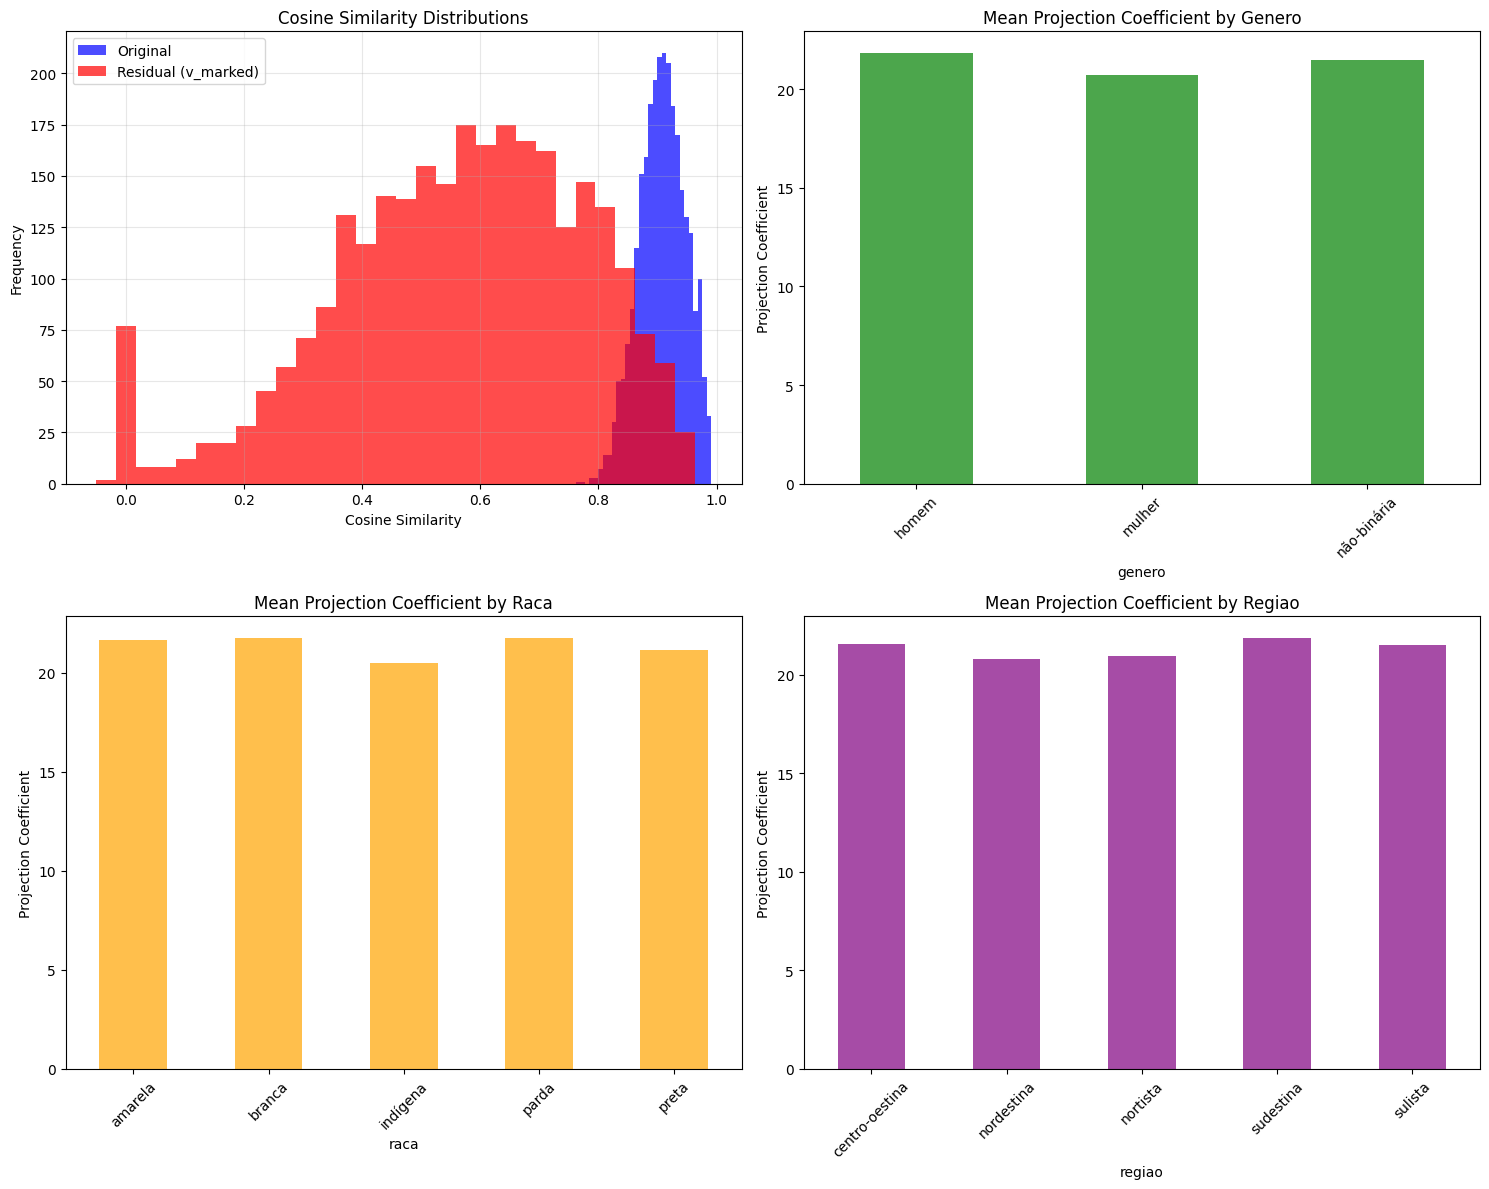

In [15]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribution of similarity values
axes[0, 0].hist(original_analysis['similarity_values'].numpy(), alpha=0.7, bins=30, label='Original', color='blue')
axes[0, 0].hist(residual_analysis['similarity_values'].numpy(), alpha=0.7, bins=30, label='Residual (v_marked)', color='red')
axes[0, 0].set_title('Cosine Similarity Distributions')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Projection coefficients by genero
genero_stats = projection_analysis_df.groupby('genero')['projection_coefficient'].agg(['mean', 'std'])
genero_stats['mean'].plot(kind='bar', ax=axes[0, 1], color='green', alpha=0.7)
axes[0, 1].set_title('Mean Projection Coefficient by Genero')
axes[0, 1].set_ylabel('Projection Coefficient')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Projection coefficients by raca
raca_stats = projection_analysis_df.groupby('raca')['projection_coefficient'].agg(['mean', 'std'])
raca_stats['mean'].plot(kind='bar', ax=axes[1, 0], color='orange', alpha=0.7)
axes[1, 0].set_title('Mean Projection Coefficient by Raca')
axes[1, 0].set_ylabel('Projection Coefficient')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Projection coefficients by regiao
regiao_stats = projection_analysis_df.groupby('regiao')['projection_coefficient'].agg(['mean', 'std'])
regiao_stats['mean'].plot(kind='bar', ax=axes[1, 1], color='purple', alpha=0.7)
axes[1, 1].set_title('Mean Projection Coefficient by Regiao')
axes[1, 1].set_ylabel('Projection Coefficient')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/home/joaquino/portuguese-llm/embeddings/plots/projection_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Results

## Graph Analysis with Similarity Weights

Use similarities as edge weights in a graph and apply community detection algorithms to find connected components.

In [16]:
# Install required libraries for graph analysis
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ Installed {package}")
    except Exception as e:
        print(f"❌ Failed to install {package}: {e}")

# Install required packages
packages = ["networkx", "community", "python-louvain"]
for package in packages:
    install_package(package)

# Import graph libraries
import networkx as nx
try:
    import community as community_louvain  # python-louvain
    print("✓ Imported community detection library")
except ImportError:
    print("❌ Community detection library not available")
    community_louvain = None

print("Graph analysis libraries ready!")

✓ Installed networkx
✓ Installed networkx
✓ Installed community
✓ Installed community
✓ Installed python-louvain
✓ Installed python-louvain
✓ Imported community detection library
Graph analysis libraries ready!
✓ Imported community detection library
Graph analysis libraries ready!


In [17]:
def create_similarity_graph(similarity_values, indices, threshold=0.0, use_weights=True):
    """
    Create a NetworkX graph from similarity values
    
    Args:
        similarity_values: tensor of similarity values
        indices: tensor of indices for the similarity pairs
        threshold: minimum similarity to create an edge
        use_weights: whether to use similarity as edge weights
    
    Returns:
        NetworkX graph
    """
    G = nx.Graph()
    
    # Add all nodes (even isolated ones)
    n_nodes = int(indices.max().item()) + 1
    G.add_nodes_from(range(n_nodes))
    
    # Add edges with similarity above threshold
    edge_count = 0
    for idx_pos in range(len(similarity_values)):
        i, j = indices[idx_pos][0].item(), indices[idx_pos][1].item()
        sim = similarity_values[idx_pos].item()
        
        if sim >= threshold:
            if use_weights:
                G.add_edge(i, j, weight=sim, similarity=sim)
            else:
                G.add_edge(i, j, similarity=sim)
            edge_count += 1
    
    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"Threshold: {threshold}, Edges added: {edge_count}")
    
    return G

# Create graphs for different similarity thresholds
# Using meaningful thresholds for cosine similarity (-1 to 1 range):
# 0.1: weak positive similarity
# 0.3: moderate positive similarity  
# 0.5: strong positive similarity
# 0.7: very strong positive similarity
thresholds = [0.1, 0.3, 0.5, 0.7]

print("Creating graphs for ORIGINAL embeddings:")
original_graphs = {}
for threshold in thresholds:
    print(f"\nThreshold {threshold}:")
    original_graphs[threshold] = create_similarity_graph(
        original_analysis['similarity_values'], 
        original_analysis['indices'], 
        threshold=threshold
    )

print("\n" + "="*50)
print("Creating graphs for RESIDUAL embeddings (v_marked):")
residual_graphs = {}
for threshold in thresholds:
    print(f"\nThreshold {threshold}:")
    residual_graphs[threshold] = create_similarity_graph(
        residual_analysis['similarity_values'], 
        residual_analysis['indices'], 
        threshold=threshold
    )

Creating graphs for ORIGINAL embeddings:

Threshold 0.1:
Created graph with 75 nodes and 2775 edges
Threshold: 0.1, Edges added: 2775

Threshold 0.3:
Created graph with 75 nodes and 2775 edges
Threshold: 0.3, Edges added: 2775

Threshold 0.5:
Created graph with 75 nodes and 2775 edges
Threshold: 0.5, Edges added: 2775

Threshold 0.7:
Created graph with 75 nodes and 2775 edges
Threshold: 0.7, Edges added: 2775

Creating graphs for RESIDUAL embeddings (v_marked):

Threshold 0.1:
Created graph with 75 nodes and 2674 edges
Threshold: 0.1, Edges added: 2674

Threshold 0.3:
Created graph with 75 nodes and 2478 edges
Threshold: 0.3, Edges added: 2478

Threshold 0.5:
Created graph with 75 nodes and 2478 edges
Threshold: 0.3, Edges added: 2478

Threshold 0.5:
Created graph with 75 nodes and 1763 edges
Threshold: 0.5, Edges added: 1763

Threshold 0.7:
Created graph with 75 nodes and 798 edges
Threshold: 0.7, Edges added: 798
Created graph with 75 nodes and 1763 edges
Threshold: 0.5, Edges added:

In [18]:
def analyze_graph_communities(G, df, graph_name, config_cols):
    """
    Analyze communities in a graph using various algorithms
    """
    print(f"\n{graph_name} - Graph Community Analysis:")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    
    # Basic connectivity analysis
    connected_components = list(nx.connected_components(G))
    print(f"Connected components: {len(connected_components)}")
    
    component_sizes = [len(comp) for comp in connected_components]
    print(f"Component sizes: {sorted(component_sizes, reverse=True)[:10]}")  # Top 10 largest
    
    results = {
        'connected_components': connected_components,
        'component_sizes': component_sizes,
        'communities': {}
    }
    
    # Only proceed with community detection if graph is connected enough
    if G.number_of_edges() > 0:
        # 1. Louvain algorithm (if available)
        if community_louvain is not None:
            try:
                louvain_communities = community_louvain.best_partition(G, weight='weight')
                n_louvain = len(set(louvain_communities.values()))
                print(f"Louvain communities: {n_louvain}")
                results['communities']['louvain'] = louvain_communities
            except Exception as e:
                print(f"Louvain failed: {e}")
        
        # 2. Greedy modularity communities
        try:
            greedy_communities = list(nx.community.greedy_modularity_communities(G, weight='weight'))
            n_greedy = len(greedy_communities)
            print(f"Greedy modularity communities: {n_greedy}")
            results['communities']['greedy'] = greedy_communities
        except Exception as e:
            print(f"Greedy modularity failed: {e}")
        
        # 3. Label propagation
        try:
            label_communities = list(nx.community.label_propagation_communities(G))
            n_label = len(label_communities)
            print(f"Label propagation communities: {n_label}")
            results['communities']['label_propagation'] = label_communities
        except Exception as e:
            print(f"Label propagation failed: {e}")
    
    # Analyze communities by configuration
    if 'louvain' in results['communities']:
        analyze_communities_by_config(results['communities']['louvain'], df, config_cols, "Louvain")
    elif 'greedy' in results['communities']:
        greedy_dict = {node: i for i, community in enumerate(results['communities']['greedy']) 
                      for node in community}
        analyze_communities_by_config(greedy_dict, df, config_cols, "Greedy Modularity")
    
    return results

def analyze_communities_by_config(communities_dict, df, config_cols, method_name):
    """
    Analyze how communities align with configuration attributes
    """
    print(f"\n{method_name} Communities vs Configuration:")
    
    # Convert to community assignments
    community_assignments = {}
    if isinstance(communities_dict, dict):
        # Louvain format: {node: community}
        community_assignments = communities_dict
    else:
        # Greedy format: list of sets
        for i, community in enumerate(communities_dict):
            for node in community:
                community_assignments[node] = i
    
    # Add community info to dataframe
    df_with_communities = df.copy()
    df_with_communities['community'] = [community_assignments.get(i, -1) for i in range(len(df))]
    
    # Analyze each config column
    for col in config_cols:
        print(f"\n{col.upper()}:")
        
        # Cross-tabulation of communities vs config values
        crosstab = pd.crosstab(df_with_communities['community'], df_with_communities[col])
        print(crosstab)
        
        # Calculate purity metrics
        total_nodes = len(df_with_communities)
        community_purities = []
        
        for community_id in crosstab.index:
            community_data = crosstab.loc[community_id]
            community_size = community_data.sum()
            max_config_count = community_data.max()
            purity = max_config_count / community_size if community_size > 0 else 0
            community_purities.append(purity)
            
            dominant_config = community_data.idxmax()
            print(f"  Community {community_id}: {community_size} nodes, "
                  f"{purity:.2f} purity, dominant {col}='{dominant_config}'")
        
        avg_purity = np.mean(community_purities) if community_purities else 0
        print(f"  Average purity for {col}: {avg_purity:.3f}")

# Analyze communities for all graphs
print("="*60)
print("COMMUNITY DETECTION ANALYSIS")
print("="*60)

all_results = {}

# # Analyze original embeddings graphs
# print("\n" + "="*40)
# print("ORIGINAL EMBEDDINGS")
# print("="*40)

# for threshold in thresholds:
#     graph_name = f"Original (threshold={threshold})"
#     all_results[f"original_{threshold}"] = analyze_graph_communities(
#         original_graphs[threshold], 
#         projection_analysis_df, 
#         graph_name, 
#         config_cols
#     )

# Analyze residual embeddings graphs
print("\n" + "="*40)
print("RESIDUAL EMBEDDINGS (v_marked)")
print("="*40)

for threshold in thresholds:
    graph_name = f"Residual (threshold={threshold})"
    all_results[f"residual_{threshold}"] = analyze_graph_communities(
        residual_graphs[threshold], 
        projection_analysis_df, 
        graph_name, 
        config_cols
    )

COMMUNITY DETECTION ANALYSIS

RESIDUAL EMBEDDINGS (v_marked)

Residual (threshold=0.1) - Graph Community Analysis:
Nodes: 75, Edges: 2674
Connected components: 2
Component sizes: [74, 1]
Louvain communities: 3
Greedy modularity communities: 3
Label propagation communities: 2

Louvain Communities vs Configuration:

GENERO:
genero     homem  mulher  não-binária
community                            
0              0       2           25
1             24      23            0
2              1       0            0
  Community 0: 27 nodes, 0.93 purity, dominant genero='não-binária'
  Community 1: 47 nodes, 0.51 purity, dominant genero='homem'
  Community 2: 1 nodes, 1.00 purity, dominant genero='homem'
  Average purity for genero: 0.812

RACA:
raca       amarela  branca  indígena  parda  preta
community                                         
0                6       6         5      5      5
1                9       8        10     10     10
2                0       1         0      0      

In [19]:
def visualize_graph_communities(G, communities_dict, df, config_col, title, max_nodes=100):
    """
    Visualize graph communities with configuration coloring
    """
    if G.number_of_nodes() > max_nodes:
        print(f"Graph too large ({G.number_of_nodes()} nodes), creating summary visualization instead")
        
        # Create a summary plot for large graphs
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Community size distribution
        if isinstance(communities_dict, dict):
            community_counts = {}
            for node, comm in communities_dict.items():
                community_counts[comm] = community_counts.get(comm, 0) + 1
            sizes = list(community_counts.values())
        else:
            sizes = [len(community) for community in communities_dict]
        
        ax1.hist(sizes, bins=min(20, len(sizes)), alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Tamanho da Comunidade (Número de Nós)', fontsize=12)
        ax1.set_ylabel('Frequência', fontsize=12)
        ax1.set_title(f'{title}\nDistribuição do Tamanho das Comunidades', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.text(0.02, 0.98, f'Total: {len(sizes)} comunidades', transform=ax1.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Plot 2: Configuration distribution in communities
        if isinstance(communities_dict, dict):
            df_with_communities = df.copy()
            df_with_communities['community'] = [communities_dict.get(i, -1) for i in range(len(df))]
            
            config_by_community = df_with_communities.groupby(['community', config_col]).size().unstack(fill_value=0)
            
            # Translate config_col for better display
            config_labels = {
                'genero': 'Gênero',
                'raca': 'Raça', 
                'regiao': 'Região'
            }
            display_config = config_labels.get(config_col, config_col.title())
            
            config_by_community.plot(kind='bar', stacked=True, ax=ax2, alpha=0.8, width=0.8)
            ax2.set_xlabel('ID da Comunidade', fontsize=12)
            ax2.set_ylabel('Número de Nós', fontsize=12)
            ax2.set_title(f'{title}\nDistribuição de {display_config} por Comunidade', fontsize=14, fontweight='bold')
            ax2.legend(title=display_config, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
            ax2.tick_params(axis='x', rotation=45)
            ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Layout with better spacing
    pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
    
    # Plot 1: Communities
    if isinstance(communities_dict, dict):
        # Louvain format
        community_values = [communities_dict.get(node, 0) for node in G.nodes()]
        n_communities = len(set(community_values))
    else:
        # Convert greedy format to dict
        comm_dict = {}
        for i, community in enumerate(communities_dict):
            for node in community:
                comm_dict[node] = i
        community_values = [comm_dict.get(node, 0) for node in G.nodes()]
        n_communities = len(communities_dict)
    
    # Draw edges first (lighter)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, edge_color='gray', ax=ax1)
    
    # Draw nodes with community colors
    nodes = nx.draw_networkx_nodes(G, pos, node_color=community_values, 
                                  node_size=400, cmap=plt.cm.Set3, 
                                  alpha=0.8, ax=ax1)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax1)
    
    ax1.set_title(f"{title}\nComunidades Detectadas (Louvain)\n{n_communities} comunidades, {G.number_of_edges()} conexões", 
                 fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Plot 2: Configuration coloring - FIXED COLOR MAPPING
    config_values = df[config_col].iloc[list(G.nodes())]
    unique_configs = sorted(config_values.unique())
    
    # Create explicit color mapping that matches exactly between nodes and legend
    color_map = {config: plt.cm.tab10(i / max(1, len(unique_configs) - 1)) 
                for i, config in enumerate(unique_configs)}
    
    # Get actual colors for each node (not indices)
    node_colors = [color_map[config_values.iloc[i]] for i in range(len(G.nodes()))]
    
    # Draw edges first (lighter)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, edge_color='gray', ax=ax2)
    
    # Draw nodes with config colors - use explicit colors, not colormap
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                                  node_size=400, alpha=0.8, ax=ax2)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax2)
    
    # Translate config_col for better display
    config_labels = {
        'genero': 'Gênero',
        'raca': 'Raça', 
        'regiao': 'Região'
    }
    display_config = config_labels.get(config_col, config_col.title())
    
    ax2.set_title(f"{title}\nColorido por {display_config}\n{len(unique_configs)} categorias", 
                 fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Add legend for config values with MATCHING colors
    legend_elements = []
    for config in unique_configs:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                         markerfacecolor=color_map[config], 
                                         markersize=10, label=config))
    
    ax2.legend(handles=legend_elements, title=display_config, 
              bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()


Analyzing and visualizing graphs...

Residual embeddings (threshold=0.1):
  Nodes: 75
  Edges: 2674
  Louvain communities found: 3
  → Visualizing graph...


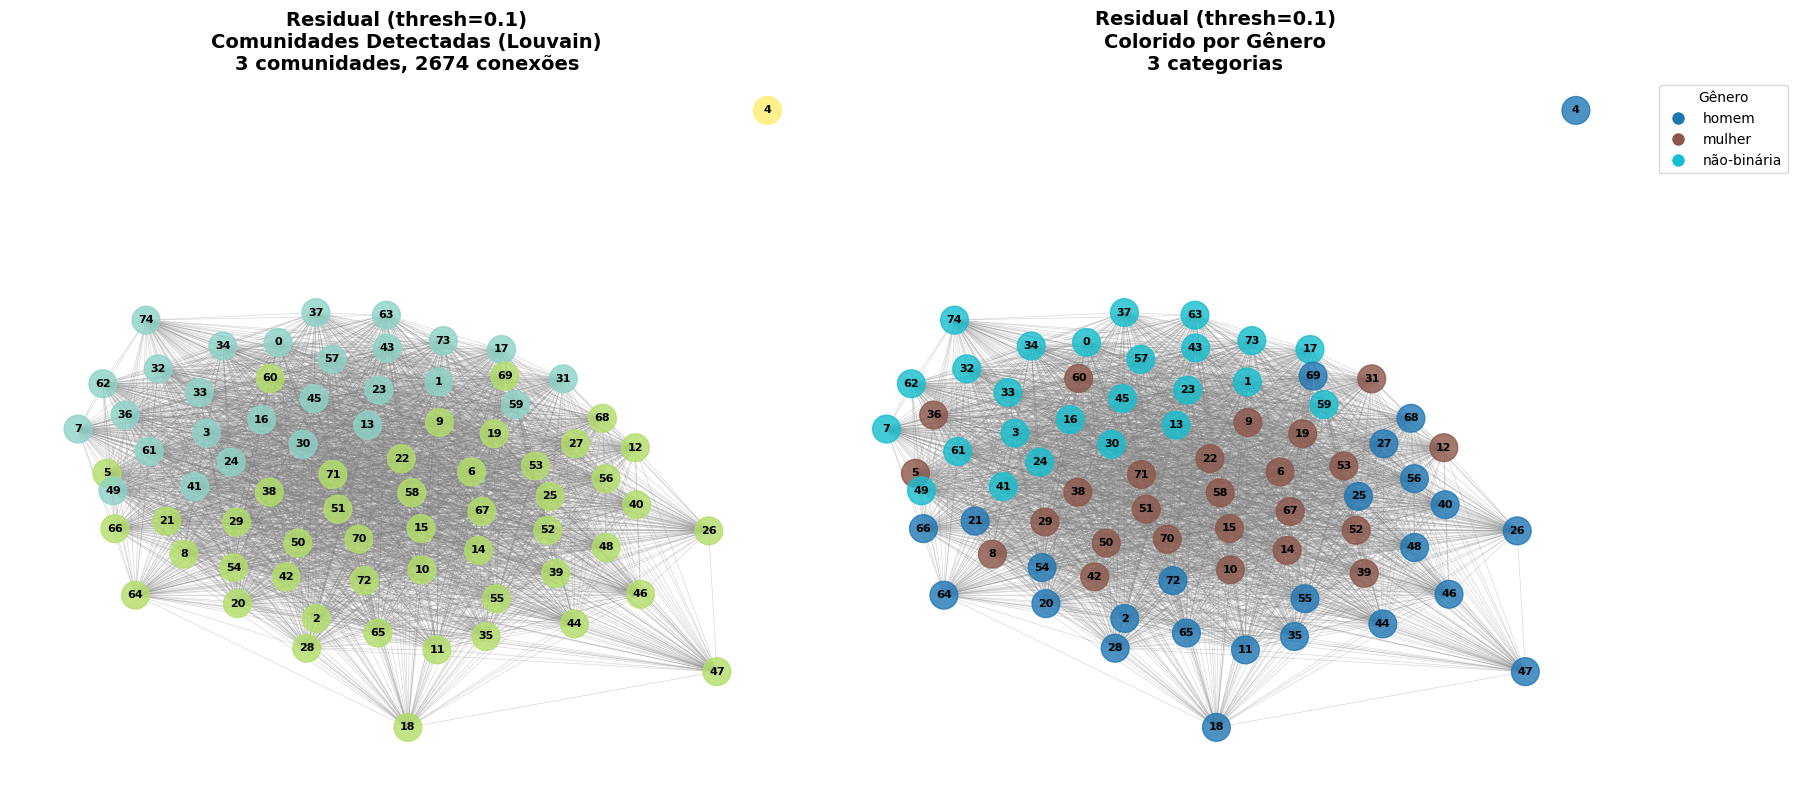


Residual embeddings (threshold=0.3):
  Nodes: 75
  Edges: 2478
  Louvain communities found: 3
  → Visualizing graph...


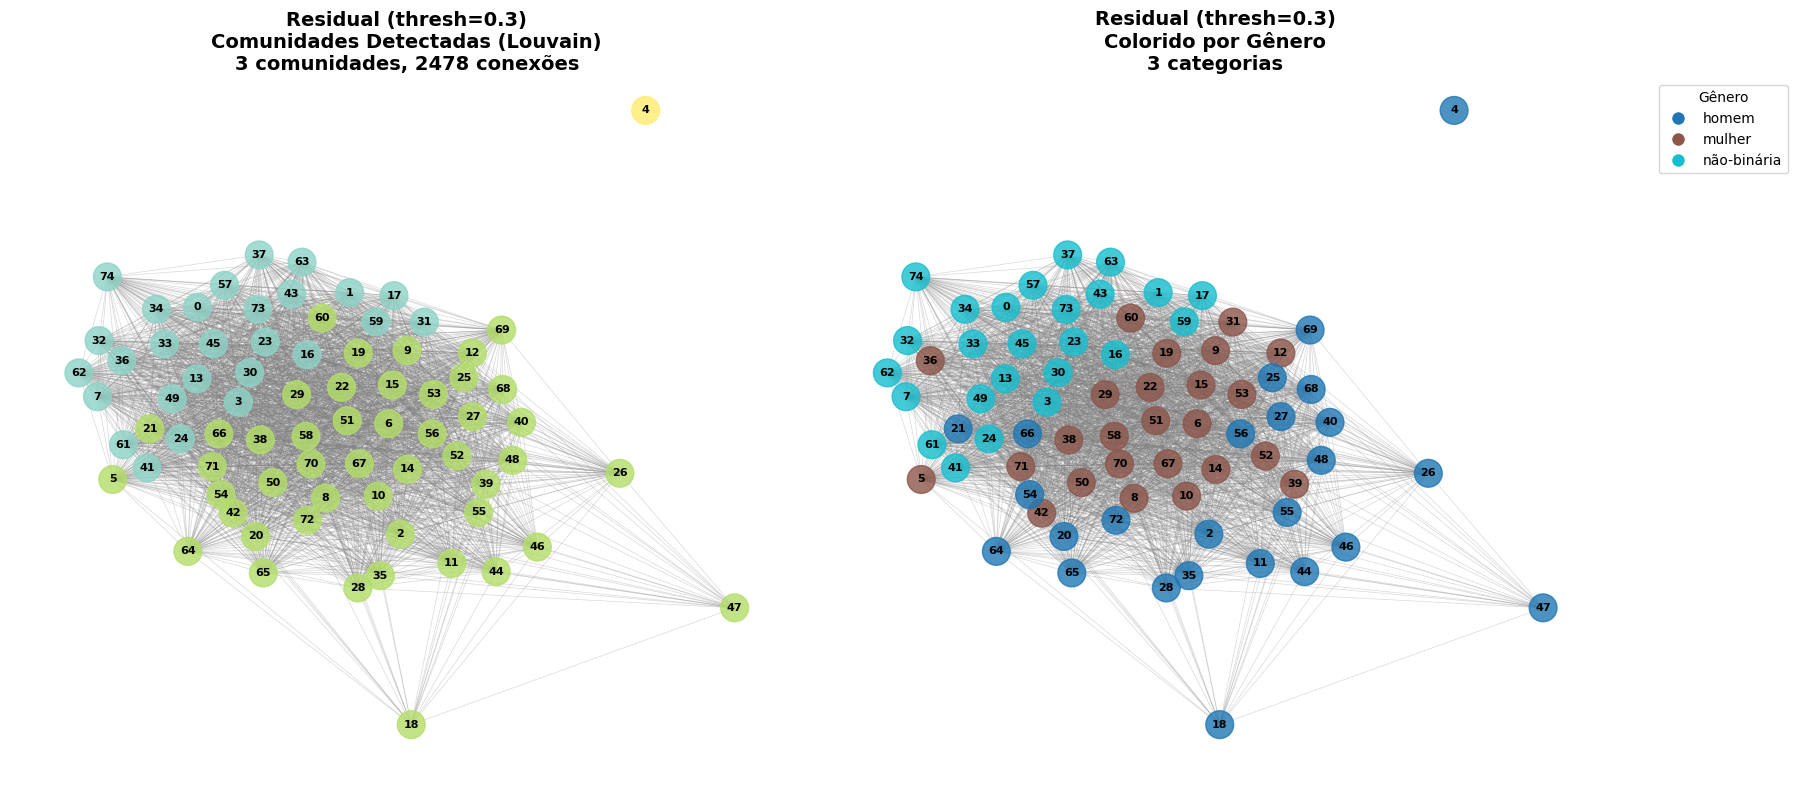


Residual embeddings (threshold=0.5):
  Nodes: 75
  Edges: 1763
  Louvain communities found: 4
  → Visualizing graph...


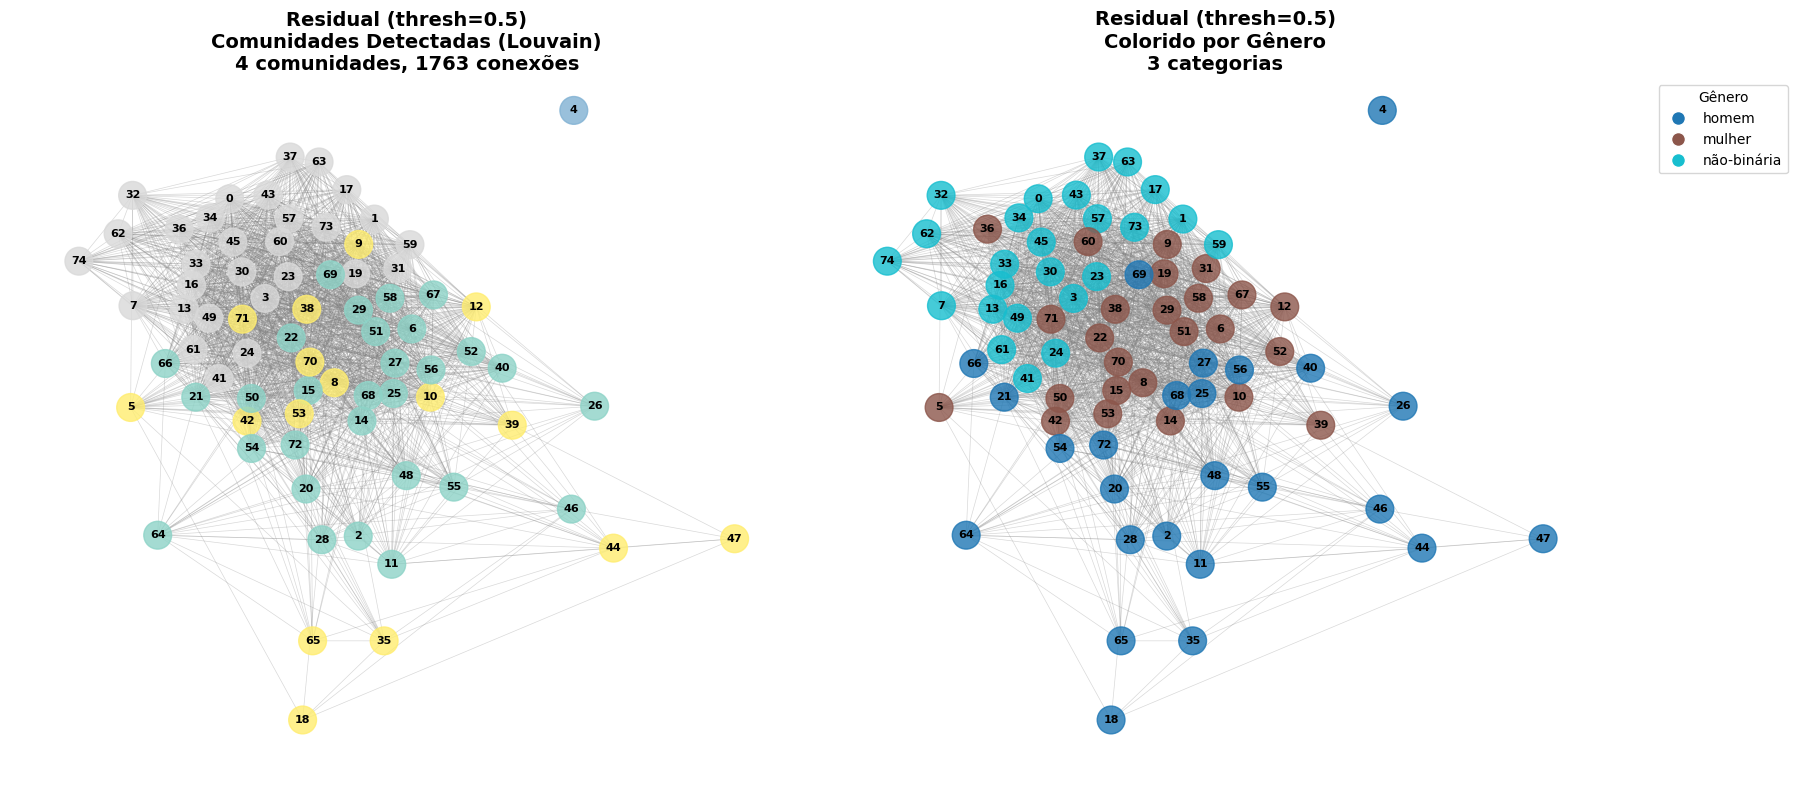


Residual embeddings (threshold=0.7):
  Nodes: 75
  Edges: 798
  Louvain communities found: 7
  → Visualizing graph...


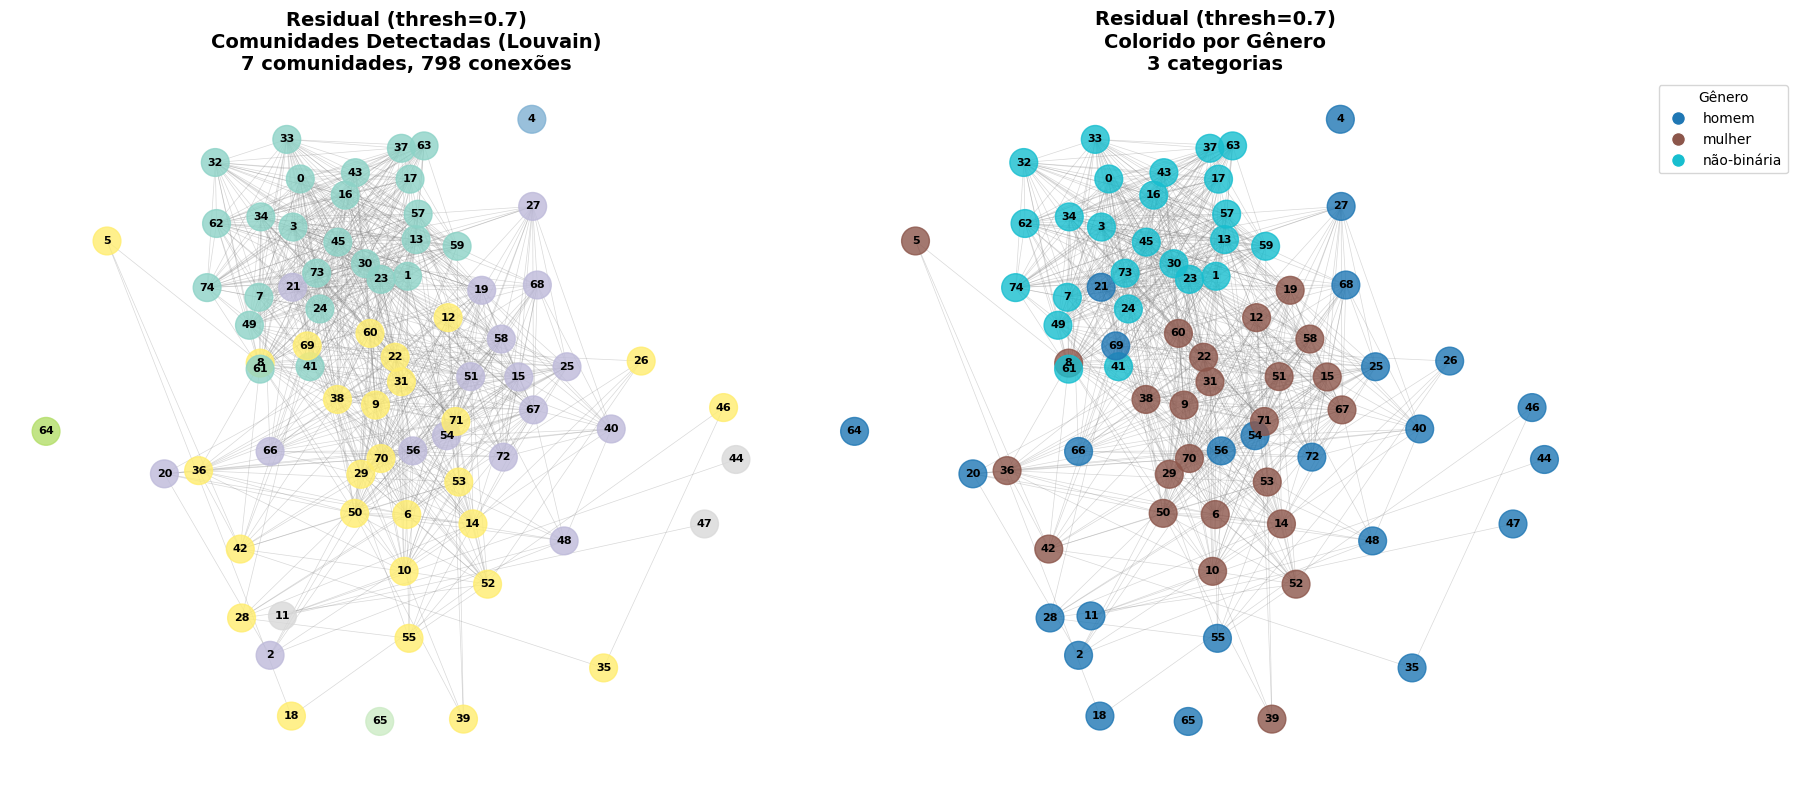

In [20]:

# Visualize specific graphs (smaller ones and force visualization for analysis)
print("\nAnalyzing and visualizing graphs...")
for threshold in thresholds:
    # Always show information about residual graphs
    print(f"\nResidual embeddings (threshold={threshold}):")
    print(f"  Nodes: {residual_graphs[threshold].number_of_nodes()}")
    print(f"  Edges: {residual_graphs[threshold].number_of_edges()}")
    
    res_key = f"residual_{threshold}"
    if res_key in all_results and 'louvain' in all_results[res_key]['communities']:
        communities = all_results[res_key]['communities']['louvain']
        print(f"  Louvain communities found: {len(set(communities.values()))}")
    elif res_key in all_results and 'greedy' in all_results[res_key]['communities']:
        communities = all_results[res_key]['communities']['greedy']
        print(f"  Greedy communities found: {len(communities)}")
    else:
        communities = {}
        print(f"  No communities found")
    
    # Visualize if graph has reasonable size (increased limit)
    if residual_graphs[threshold].number_of_nodes() <= 100:
        print(f"  → Visualizing graph...")
        visualize_graph_communities(
            residual_graphs[threshold], 
            communities, 
            projection_analysis_df, 
            'genero', 
            f"Residual (thresh={threshold})"
        )
    else:
        print(f"  → Graph too large for visualization ({residual_graphs[threshold].number_of_nodes()} nodes)")
        
        # For large graphs, create a simplified visualization with community info
        if communities:
            print(f"  → Showing community statistics instead:")
            if isinstance(communities, dict):
                # Count nodes per community
                community_counts = {}
                for node, comm in communities.items():
                    community_counts[comm] = community_counts.get(comm, 0) + 1
                
                print(f"     Community sizes: {sorted(community_counts.values(), reverse=True)[:10]}")
                
                # Show genero distribution in communities
                df_with_communities = projection_analysis_df.copy()
                df_with_communities['community'] = [communities.get(i, -1) for i in range(len(projection_analysis_df))]
                
                genero_by_community = df_with_communities.groupby(['community', 'genero']).size().unstack(fill_value=0)
                print(f"     Genero distribution by community:")
                print(genero_by_community.head())

In [21]:
def node_to_row(node_id, df=None):
    """
    Convert a graph node ID (integer index) to the corresponding DataFrame row.
    
    Args:
        node_id (int): The node ID from the graph (0-based index)
        df (pd.DataFrame, optional): The DataFrame to use. Defaults to projection_analysis_df
    
    Returns:
        pd.Series: The corresponding row from the DataFrame
    """
    if df is None:
        df = projection_analysis_df
    
    if node_id < 0 or node_id >= len(df):
        raise ValueError(f"Node ID {node_id} is out of range [0, {len(df)-1}]")
    
    return df.iloc[node_id]

def nodes_to_rows(node_ids, df=None, return_df=False):
    """
    Convert multiple graph node IDs to their corresponding DataFrame rows.
    
    Args:
        node_ids (list or iterable): List of node IDs from the graph (0-based indices)
        df (pd.DataFrame, optional): The DataFrame to use. Defaults to projection_analysis_df
        return_df (bool): If True, return as DataFrame; if False, return as list of Series
    
    Returns:
        list of pd.Series or pd.DataFrame: The corresponding rows from the DataFrame
    """
    if df is None:
        df = projection_analysis_df
    
    # Validate all node IDs
    for node_id in node_ids:
        if node_id < 0 or node_id >= len(df):
            raise ValueError(f"Node ID {node_id} is out of range [0, {len(df)-1}]")
    
    rows = [df.iloc[node_id] for node_id in node_ids]
    
    if return_df:
        return pd.DataFrame(rows)
    else:
        return rows

def analyze_nodes_config(node_ids, config_cols=None, df=None):
    """
    Analyze the configuration distribution for a set of nodes.
    
    Args:
        node_ids (list): List of node IDs to analyze
        config_cols (list, optional): Configuration columns to analyze. Defaults to ['genero', 'raca', 'regiao']
        df (pd.DataFrame, optional): The DataFrame to use. Defaults to projection_analysis_df
    
    Returns:
        dict: Configuration distribution statistics
    """
    if df is None:
        df = projection_analysis_df
    if config_cols is None:
        config_cols = ['genero', 'raca', 'regiao']
    
    # Get rows for these nodes
    rows_df = nodes_to_rows(node_ids, df, return_df=True)
    
    # Analyze each configuration column
    results = {}
    for col in config_cols:
        value_counts = rows_df[col].value_counts()
        results[col] = {
            'counts': value_counts.to_dict(),
            'percentages': (value_counts / len(rows_df) * 100).to_dict(),
            'most_common': value_counts.index[0] if len(value_counts) > 0 else None
        }
    
    return results

def find_nodes_by_config(config_filters, df=None):
    """
    Find node IDs that match specific configuration criteria.
    
    Args:
        config_filters (dict): Dictionary of column: value pairs to filter by
                              e.g., {'genero': 'homem', 'raca': 'branca'}
        df (pd.DataFrame, optional): The DataFrame to use. Defaults to projection_analysis_df
    
    Returns:
        list: List of node IDs that match the criteria
    """
    if df is None:
        df = projection_analysis_df
    
    # Start with all rows
    mask = pd.Series(True, index=df.index)
    
    # Apply filters
    for col, value in config_filters.items():
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")
        mask = mask & (df[col] == value)
    
    # Return the indices (which are the node IDs)
    return mask[mask].index.tolist()

# Test the functions with some examples
print("Node-to-row mapping functions created!")
print("\nExample usage:")

# Example 1: Get a specific node's information
if len(projection_analysis_df) > 0:
    node_0_info = node_to_row(0)
    print(f"\nNode 0 configuration: {node_0_info[['genero', 'raca', 'regiao']].to_dict()}")

# Example 2: Analyze nodes in a community (if communities exist)
if 'all_results' in globals() and len(all_results) > 0:
    # Try to get some community info
    for key, results in all_results.items():
        if 'communities' in results and 'louvain' in results['communities']:
            communities = results['communities']['louvain']
            if len(communities) > 0:
                # Get first community
                first_community_nodes = [node for node, comm in communities.items() if comm == 0][:5]
                if first_community_nodes:
                    print(f"\nFirst 5 nodes in community 0 from {key}:")
                    config_analysis = analyze_nodes_config(first_community_nodes)
                    for col, stats in config_analysis.items():
                        print(f"  {col}: {stats['counts']}")
                break

# Example 3: Find nodes with specific configuration
target_nodes = find_nodes_by_config({'genero': 'homem', 'raca': 'branca'})
print(f"\nFound {len(target_nodes)} nodes with genero='homem' and raca='branca'")
if len(target_nodes) > 0:
    print(f"First few node IDs: {target_nodes[:5]}")

Node-to-row mapping functions created!

Example usage:

Node 0 configuration: {'genero': 'não-binária', 'raca': 'preta', 'regiao': 'sulista'}

First 5 nodes in community 0 from residual_0.1:
  genero: {'não-binária': 5}
  raca: {'parda': 2, 'preta': 1, 'amarela': 1, 'indígena': 1}
  regiao: {'nortista': 2, 'sulista': 1, 'nordestina': 1, 'sudestina': 1}

Found 5 nodes with genero='homem' and raca='branca'
First few node IDs: [2, 4, 18, 26, 47]
